In [62]:
using ControlSystems
using Plots
using GR
using MonteCarloMeasurements
using Optim
using Convex
using SCS
gr(size=(1000,500))

Plots.GRBackend()

In [65]:
using ControlSystems
"""
Example for designing an LQG speed controller for an electrical DC motor.
"""

# Constants
Ke = 0.006156                                # electromotive force constant in V/rpm
Kt                      = 0.0728             # Torque constant (Nm/A)
J                       = 2.8*700e-6;        # Inertia of motor plus load (kgm^2)
Rel                     = 0.11;              # DC motor resistance (Ω)
L                       = 34e-6;             # DC motor inductance (H)

# helper to convert a scalar into an 1x1 Matrix
mat(sc) = reshape([sc],1,1)

# Create an instance of a DC motor model in state space form.
# Ke: electromotive force constant in V/rpm
# Kt: torque constant (Nm/A)
# L: Inductance; R: Resistance, J: Inertia; b: viscous friction coefficient
function motor(Ke, Kt, L, R, J, b=1e-3)
    Ke1 = Ke*60.0/2π   # change unit to rad/s
    A = [-b/J     Kt/J
         -Ke1/L   -R/L];
    B = [0
        1/L];
    C = [1     0];
    D = 0;
    sys = ss(A, B, C, D);
end

p60 = motor(Ke, Kt, L, Rel, J)
stepplot(p60, 0.2, 0.001)
bodeplot(p60)

# LQR control
Q = [1.     0;
     0      1]

R = 20.
K = lqr(p60.A, p60.B, Q, R)
# needs to be modified if Nbar is not a scalar
Nbar = 1. / (p60.D - (p60.C - p60.D*K) * inv(p60.A - p60.B*K) * p60.B)

# Kalman filter based observer
Vd = [10.     0   # covariance of the speed estimation
     0       10]; # covariance of the current estimation
Vn = 0.04;       # covariance for the speed measurement (radians/s)^2
G = LQG(p60, Q, mat(R), Vd, mat(Vn))
Gcl = G[:cl]
T = G[:T]
S = G[:S];
f1 = sigmaplot([S,T],logspace(-3,3,1000))
f2 = stepplot(Gcl, label=["Closed loop system using LQG"])
Plots.plot(f1,f2)

LoadError: MethodError: no method matching step(::StateSpace{Continuous, Float64}, ::Float64, ::Float64)
[0mClosest candidates are:
[0m  step(::LTISystem, ::Real; kwargs...) at /Users/adityasengupta/.julia/packages/ControlSystems/nIXAR/src/timeresp.jl:32
[0m  step(::AbstractStateSpace, [91m::AbstractVector{T} where T[39m; method) at /Users/adityasengupta/.julia/packages/ControlSystems/nIXAR/src/timeresp.jl:14
[0m  step(::LTISystem; kwargs...) at /Users/adityasengupta/.julia/packages/ControlSystems/nIXAR/src/timeresp.jl:33

In [66]:
?stepplot

search: stepplot stepplot!



```
stepplot(sys[, tfinal]; kwargs...) or stepplot(sys[, t]; kwargs...)
```

Plot step response of  `sys` until final time `tfinal` or at time points in the vector `t`. If not defined, suitable values are chosen based on `sys`. See also [`step`](@ref)

`kwargs` is sent as argument to Plots.plot.


In [64]:
# Generate random problem data
m = 4;  n = 5
A = randn(m, n); b = randn(m, 1)

# Create a (column vector) variable of size n x 1.
x = Variable(n)

# The problem is to minimize ||Ax - b||^2 subject to x >= 0
# This can be done by: minimize(objective, constraints)
problem = minimize(sumsquares(A * x - b), [x >= 0])

# Solve the problem by calling solve!
solve!(problem, SCS.Optimizer)

# Check the status of the problem
problem.status # :Optimal, :Infeasible, :Unbounded etc.

# Get the optimal value
problem.optval

----------------------------------------------------------------------------
	SCS v2.1.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 31, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 8, constraints m = 15
Cones:	primal zero / dual free vars: 1
	linear vars: 6
	soc vars: 8, soc blks: 2
Setup time: 2.08e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.69e+19  1.18e+19  1.00e+00 -3.43e+19  2.63e+18  3.63e+19  7.45e-05 
    40| 1.54e-09  2.80e-09  8.03e-10  7.88e-10 -1.58e-11  1.74e-16  3.27e-04 
-----------------------------------------------

7.876273407243769e-10

In [46]:
P = tf(1, [1, 3, 3, 1])

TransferFunction{Continuous, ControlSystems.SisoRational{Int64}}
         1
-------------------
s^3 + 3s^2 + 3s + 1

Continuous-time transfer function model

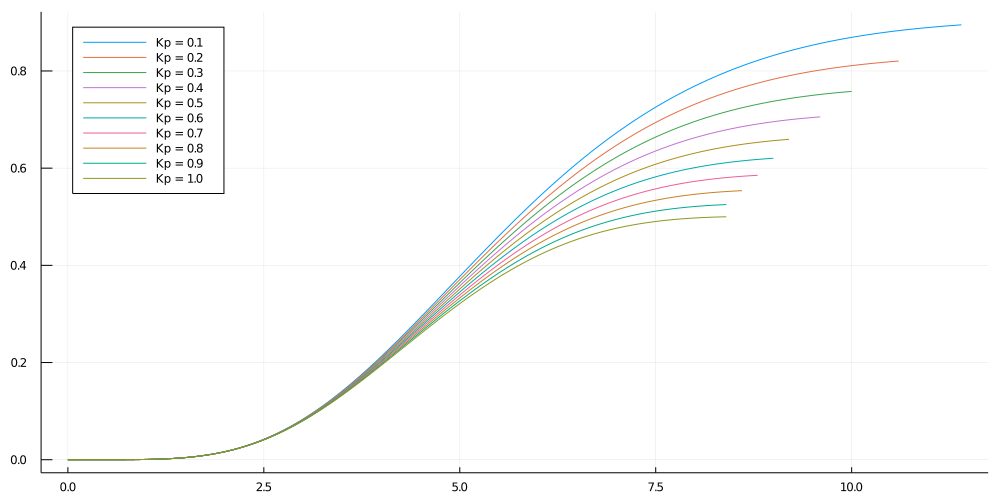

In [47]:
p = plot(legend=:topleft)
for Kp in 0.1:0.1:1.0
    _, t, x = step(feedback(Kp*P, 1))
    plot!(t, x[:,1], label="Kp = "* string(Kp))
end
p

In [24]:
damp(P)

([0.9999967152570559, 0.9999967152570559, 1.000006569518257], [0.9999999999838154, 0.9999999999838154, 1.0], ComplexF64[-0.9999967152408714 + 5.689374167928025e-6im, -0.9999967152408714 - 5.689374167928025e-6im, -1.000006569518257 + 0.0im])

In [25]:
pid(;kp=1, ki=1, kd=1)

TransferFunction{Continuous, ControlSystems.SisoRational{Int64}}
s^2 + s + 1
-----------
     s

Continuous-time transfer function model

In [26]:
pid(;kp=300)

TransferFunction{Continuous, ControlSystems.SisoRational{Float64}}
300.0
-----
 1.0

Continuous-time transfer function model

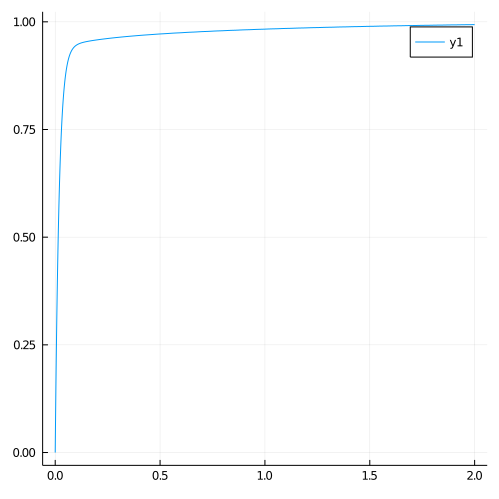

In [38]:
C = pid(;kp=350, ki=300, kd=50)
y, t, _ = step(feedback(C*tf(1, [1, 10, 20])), 2.0)
plot(t, y)
# this matches https://ctms.engin.umich.edu/CTMS/index.php?example=Introduction&section=ControlPID
# note that unity feedback w `feedback(sys, 1)` is implemented here as `feedback(sys)` and isn't the same as in MATLAB

In [28]:
feedback(C*tf(1, [1, 10, 20]))

TransferFunction{Continuous, ControlSystems.SisoRational{Int64}}
   50s^2 + 350s + 300
------------------------
s^3 + 60s^2 + 370s + 300

Continuous-time transfer function model

In [29]:
?gangoffourplot

search: gangoffourplot gangoffour



```
fig = gangoffourplot(P::LTISystem, C::LTISystem; minimal=true, plotphase=false, kwargs...)
gangoffourplot(P::Union{Vector, LTISystem}, C::Vector; minimal=true, plotphase=false, kwargs...)
```

Gang-of-Four plot. `kwargs` is sent as argument to Plots.plot.


  0.150799 seconds (123.84 k allocations: 14.778 MiB, 90.29% compilation time)
Final cost: 0.09900300786845756


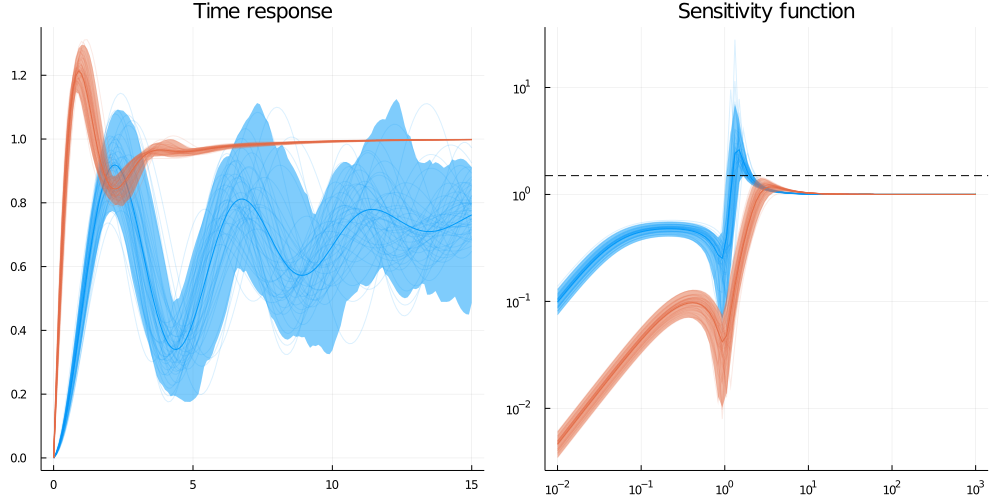

In [56]:
# In this script, we will design a PID controller by optimization. The system model has uncertain parameters, and we pay a price not only for poor performance of the closed-loop system, but also for a high variance in the performance. In addition to this, we place a constraint on the 90:th percentile of the maximum of the sensitivity function. This way, we will get a doubly robust controller as a result :)
# We start by defining the system and some initial controller parameters
using MonteCarloMeasurements, Optim, ControlSystems, Plots
using MonteCarloMeasurements: ∓
p = 1 ∓ 0.1
ζ = 0.1 ∓ 0.05
ω = 1 ∓ 0.1
P = tf([p*ω], [1, 2ζ*ω, ω^2])
w = exp10.(LinRange(-2,3,100))
params = [1,0.1,0.1]
Msc = 1.5 # Constraint on Ms

# We now define the cost function, which includes the constraint on the maximum sensitivity function
function cost(params)
    kp,ki,kd = params
    C = pid(kp=kp,ki=ki,kd=kd)
    G = feedback(P*C) # Closed-loop system
    S = 1/(1 + P*C)   # Sensitivity function
    local Gd
    try
        @unsafe Gd = c2d(G,0.1) # Discretize the system. This might fail for some parameters, so we catch these cases and return a high value
    catch
        return 1000
    end
    y  = step(Gd,15)[1][:] # This is the time-domain simulation
    Ms = maximum(bode(S, w)[1]) # Maximum of the sensitivity function
    q  = quantile(Ms, 0.9)
    performance = mean(abs, 1 .- y)   # This is our performance measure
    robustness = (q > Msc ? 10000(q-Msc) : 0) # This is our robustness constraint
    variance = 10std(performance)     # This is the price we pay for high variance in the performance
    mean(performance) + robustness + variance
end

# We are now ready to test the cost function. This will take very long time to compile the first time it's called since we use StaticParticles (~60s on my machine), but should be very fast after that (~6ms)
@time cost(params)
#
res = Optim.optimize(cost, params, SimulatedAnnealing(), Optim.Options(iterations=200, show_trace=false));
println("Final cost: ", res.minimum)
# We can now perform the same computations as above to visualize the found controller
fig = plot(layout=2)
for params = (params, res.minimizer)
    kp,ki,kd = params
    C  = pid(kp =kp,ki =ki,kd =kd)
    G  = feedback(P*C)
    S  = 1/(1 + P*C)
    @unsafe Gd = c2d(G,0.1)
    y,t,_ = step(Gd,15)
    y     = y[:]
    mag   = bode(S, w)[1][:]
    plot!(t,y, title="Time response", subplot=1, legend=false)
    plot!(w, mag, title="Sensitivity function", xscale=:log10, yscale=:log10, subplot=2, legend=false)
end
hline!([Msc], l=(:black, :dash), subplot=2)
fig

# Other things that could potentially be relevant is adding a probabilistic constraint on the time-domain output, such as the probability of having the step response go above 1.5 must be < 0.05 etc.

In [41]:
res.minimizer

3-element Vector{Float64}:
 7.4752632944296185
 2.689984251048794
 2.6380367902450437

In [49]:
y

151-element Vector{StaticParticles{Float64, 100}}:
 0.0
 0.827 ± 0.04
 0.978 ± 0.013
 1.01 ± 0.006
 1.01 ± 0.0073
 1.01 ± 0.0079
 1.01 ± 0.0081
 1.0 ± 0.008
 1.0 ± 0.0079
 1.0 ± 0.0077
 0.999 ± 0.0076
 0.998 ± 0.0074
 0.996 ± 0.0072
 ⋮
 1.0 ± 1.8e-5
 1.0 ± 1.7e-5
 1.0 ± 1.6e-5
 1.0 ± 1.5e-5
 1.0 ± 1.4e-5
 1.0 ± 1.3e-5
 1.0 ± 1.2e-5
 1.0 ± 1.1e-5
 1.0 ± 1.0e-5
 1.0 ± 9.3e-6
 1.0 ± 8.5e-6
 1.0 ± 7.9e-6